In [2]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import sidetable

In [3]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [107]:
cols_to_use = ['IDMerged', 'tripIndex', 'actStartTime', 'actEndTime','duration_travelling', 'cost_BEAM', 'actStartType', 
               'actEndType', 'duration_walking', 'duration_in_privateCar', 'duration_on_bike', 'duration_in_ridehail', 
              'distance_travelling', 'duration_in_transit', 'distance_walking','distance_bike','distance_ridehail', 
              'distance_privateCar', 'distance_transit', 'mode_choice_planned_BEAM','mode_choice_actual_BEAM', 'vehicleIds',
              'numPassengers', 'distance_mode_choice', 'replanning_status', 'reason', 'parkingType',
               'BlockGroupStart','startX', 'startY', 'bgid_start', 'tractid_start', 'juris_name_start', 'county_name_start', 'mpo_start', 
               'BlockGroupEnd', 'endX', 'endY', 'bgid_end', 'tractid_end', 'juris_name_end', 'county_name_end', 'mpo_end',  
               'duration_door_to_door', 'waitTime_no_replanning', 'waitTime_replanning', 'actPurpose', 
               'mode_choice_actual_6', 'mode_choice_actual_5', 'mode_choice_actual_4', 
               'trip_id','person_id','household_id','tour_id','primary_purpose_x','destination_logsum_x', 'trip_mode_AS_trips', 
               'logsum_trip_Potential_INEXUS', 'tour_mode_AS_tours','duration','earning','sex','race_id', 'race',
               'TAZ_x','home_x','home_y','home_taz','value_of_time', 'school_taz','workplace_taz', 'free_parking_at_work',
               'hh_size','hh_income','income_in_thousands','median_value_of_time', 'hh_value_of_time', 'home_is_urban',
               'home_is_rural', 'auto_ownership','age', 'income', 'hh_cars', 'origin_x', 
               'destination_x', 'TAZ_y', 'DRIVEALONEFREE', 'scenario', 'year', 'lever_position_price', 
               'lever_position_fleetsize', 'door_to_door_time_relative_to_baseline', 'mandatoryCat', 'tour_category',
               'DRIVEALONEPAY', 'SHARED2FREE', 'SHARED2PAY', 'SHARED3FREE', 'SHARED3PAY', 'WALK', 'BIKE', 'WALK_LOC', 'WALK_LRF', 
               'WALK_EXP', 'WALK_HVY', 'WALK_COM', 'DRIVE_LOC', 'DRIVE_LRF', 'DRIVE_EXP', 'DRIVE_HVY', 'DRIVE_COM', 'TAXI',
               'TNC_SINGLE', 'TNC_SHARED', 'income_quartiles', 'income_deciles'] # Specify the columns to read

In [372]:
#%%time
# Original stacked file
#stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_rh_price_orig = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_5_5_23.csv', usecols = cols_to_use) #usecols = cols_to_use

In [7]:
%%time
# Stacked File without outliers (removed by isolation forest)
stacked_rh_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
sf_stacked_rh_price = pd.read_csv(stacked_rh_path + 'sf_2018_stacked_rh_price_clean_ML_5_11_23.csv') #usecols = cols_to_use

<timed exec>:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 14min 7s
Wall time: 32min 25s


In [10]:
# remove the outliers
sf_stacked_rh_price_orig = sf_stacked_rh_price_orig[(sf_stacked_rh_price_orig['duration_travelling'] > 0)].reset_index(drop=True)

In [373]:
# Remove the outliers
sf_stacked_rh_price_orig = sf_stacked_rh_price_orig[(sf_stacked_rh_price_orig['duration_walking'] < 3600)&(sf_stacked_rh_price_orig['distance_walking'] < 5000)]

#### Previous Figure 5 - Density plot of the Potential INEXUS and income level

In [155]:
# We only chose three scenarios for this plot to show the differences more clearly
plot_inc_3 = sf_stacked_rh_price[(sf_stacked_rh_price['lever_position_price'] == 0)|
                         (sf_stacked_rh_price['lever_position_price'] == 0.25)|(sf_stacked_rh_price['lever_position_price'] == 8)]

In [288]:
plot_free_base = sf_stacked_rh_price[(sf_stacked_rh_price['lever_position_price'] == 0)]

In [ ]:
plot_base_high = sf_stacked_rh_price[(sf_stacked_rh_price['lever_position_price'] == 8)]

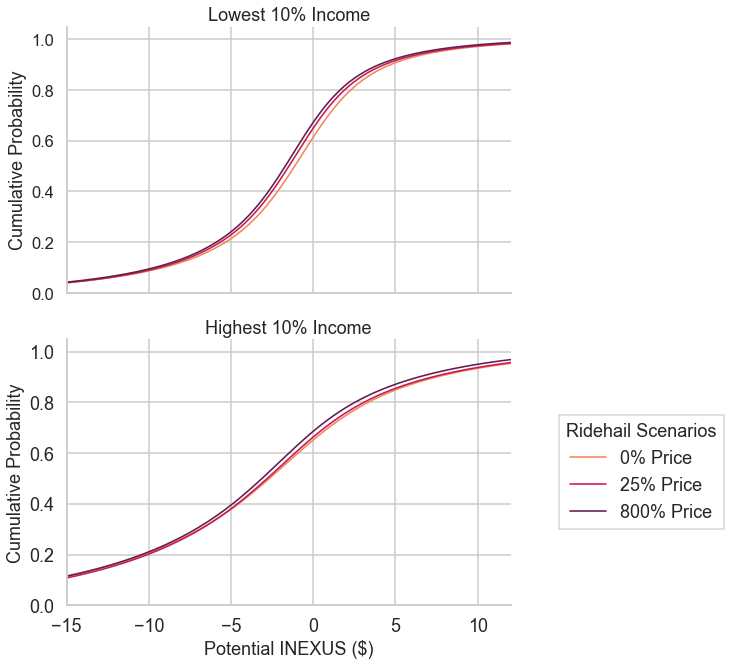

In [160]:
##### sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')],
                     row = 'income_deciles',
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =3, linewidth = 1.6, cumulative=True)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,12))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price','25% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Cumulative Probability', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)

#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

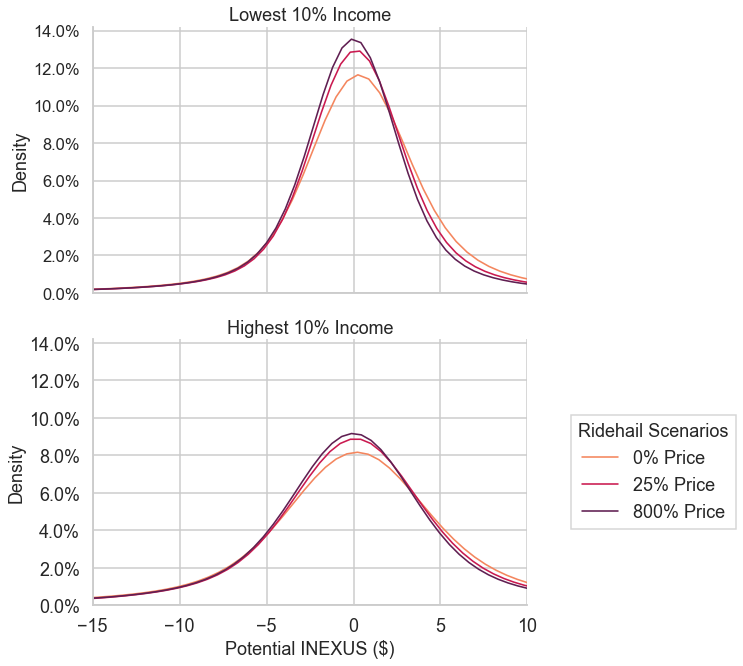

In [158]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc_3.loc[(plot_inc_3['income_deciles'] == '1stD')|
                                    (plot_inc_3['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'potential_in_dollar_2023_relative_to_baseline', bw_adjust =5, linewidth = 1.6)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '25% Price','800% Price'],
           #'0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

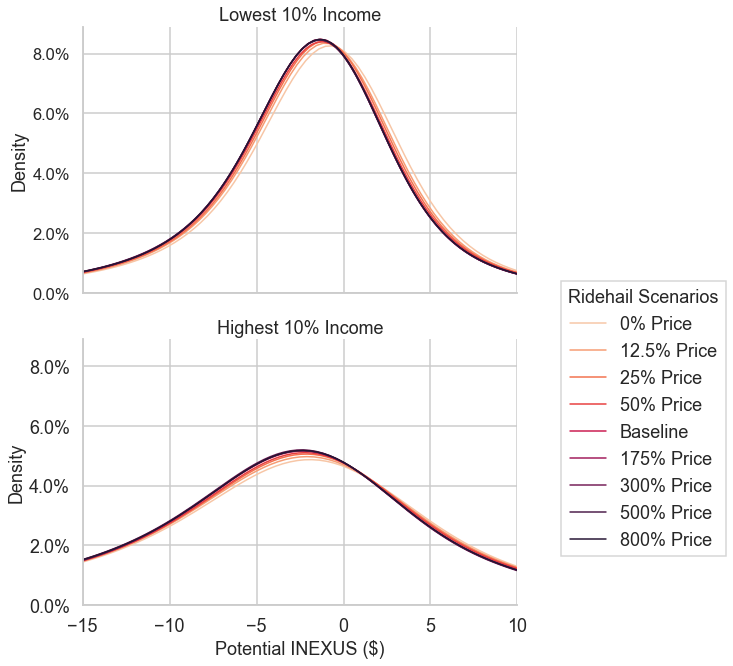

In [40]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data   
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc.loc[(plot_inc['income_deciles'] == '1stD')|
                                    (plot_inc['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-15,10))

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

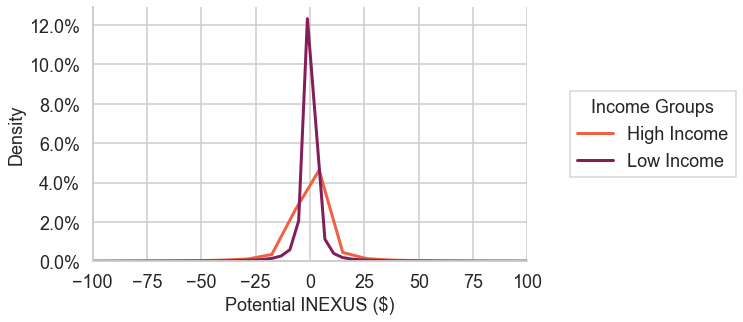

In [208]:
# Filter the DataFrame for the income groups you want to compare (1stD and 10thD)
filtered_df = plot_base_high[(plot_base_high['income_deciles'] == '1stD') |
                          (plot_base_high['income_deciles'] == '10thD')]

# Create a FacetGrid with one plot for both income groups
grid = sns.FacetGrid(filtered_df, hue='income_deciles', hue_order=['10thD', '1stD'],
                     height=5, aspect=1.5, palette="rocket_r", legend_out=True)
grid.map(sns.kdeplot, 'potential_in_dollar_2023_relative_to_baseline',
         bw_adjust=2, linewidth=3)

# Set x-axis limits to (-5, 5)
grid.set(xlim=(-100,100))

# Set labels and title
plt.xlabel('Potential INEXUS ($)', size=18)
plt.ylabel('Density', size=18)

# Customize legend for both income groups
plt.legend(title="Income Groups", labels=['High Income', 'Low Income'],
           fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.5), ncol=1, frameon=True, loc='right', prop={'size': 18})

# Format y-axis labels as percentages
formatter = FuncFormatter(lambda y, position: "{:.1f}%".format(y * 100))
grid.ax.yaxis.set_major_formatter(formatter)

# Adjust tick label sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Squash down a little
plt.subplots_adjust(top=0.9)

# Show the plot
plt.grid(True)
plt.show()

#### Figure 5 - Histograms - Potential INEXUS relative to baseline across income levels

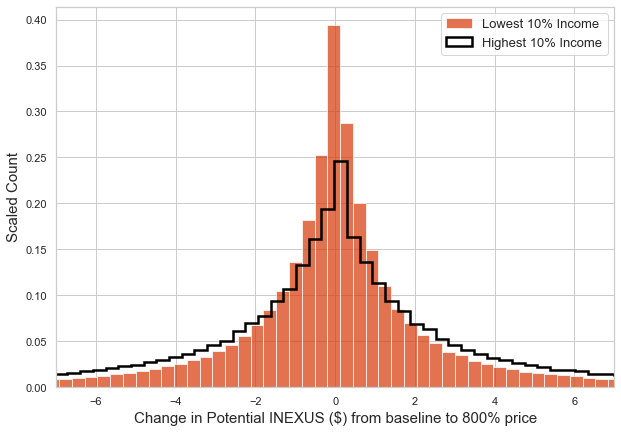

In [371]:
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm

df = plot_base_high

# Separate data for low and high-income groups
low_income = df[df['income_deciles'] == '1stD']
high_income = df[df['income_deciles'] == '10thD']

# Create histograms
plt.figure(figsize=(10,7))

# Plot a solid histogram for low income
plt.hist(low_income['potential_in_dollar_2023_relative_to_baseline'], bins=300, alpha=0.7, density=True, color='#D83706', label='Lowest 10% Income')

# Plot a non-solid histogram for high income
plt.hist(high_income['potential_in_dollar_2023_relative_to_baseline'], bins=300, alpha=1, density=True, histtype='step', edgecolor='black', linewidth=2.5, label='Highest 10% Income')

# Set y-axis to scaled count
plt.gca().set_ylabel('Scaled Count',fontdict={'fontname': 'Arial', 'fontsize': 15})

# Customize the legend with custom font
legend_font = fm.FontProperties(family='Arial', size=13)  # Define the font properties
plt.legend(prop=legend_font)

# Set x-axis limits
plt.xlim(-7, 7)

# Add titles and labels
plt.xlabel('Change in Potential INEXUS ($) from baseline to 800% price', fontdict={'fontname': 'Arial', 'fontsize': 15})

# Show the plot
plt.grid(True)
plt.show()

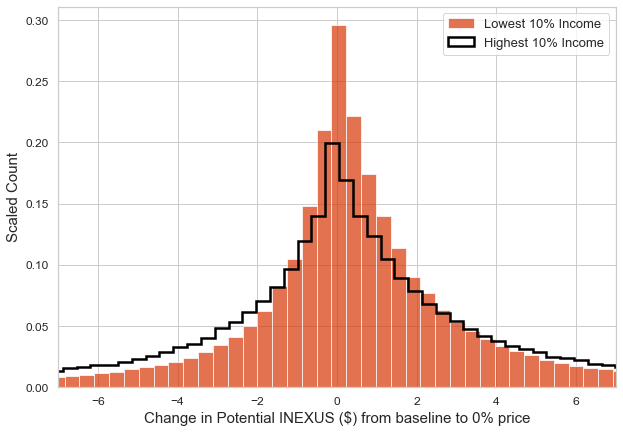

In [370]:
import matplotlib.ticker as mtick

df = plot_free_base

# Separate data for low and high-income groups
low_income = df[df['income_deciles'] == '1stD']
high_income = df[df['income_deciles'] == '10thD']

# Create histograms
plt.figure(figsize=(10,7))

# Plot a solid histogram for low income
plt.hist(low_income['potential_in_dollar_2023_relative_to_baseline'], bins=300, alpha=0.7, density=True, color='#D83706', label='Lowest 10% Income')

# Plot a non-solid histogram for high income
plt.hist(high_income['potential_in_dollar_2023_relative_to_baseline'], bins=300, alpha=1, density=True, histtype='step', edgecolor='black', linewidth=2.5, label='Highest 10% Income')

# Set y-axis to scaled count
plt.gca().set_ylabel('Scaled Count', fontdict={'fontname': 'Arial', 'fontsize': 15})

# Customize the legend with custom font
legend_font = fm.FontProperties(family='Arial', size=13)  # Define the font properties
plt.legend(prop=legend_font)

# Set x-axis limits
plt.xlim(-7, 7)

# Add titles and labels
plt.xlabel('Change in Potential INEXUS ($) from baseline to 0% price', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.xticks(fontname='Arial', fontsize=12)  # Change the font and fontsize of x-axis labels
plt.yticks(fontname='Arial', fontsize=12)  # Change the font and fontsize of x-axis labels

# Show the plot
plt.grid(True)
plt.show()

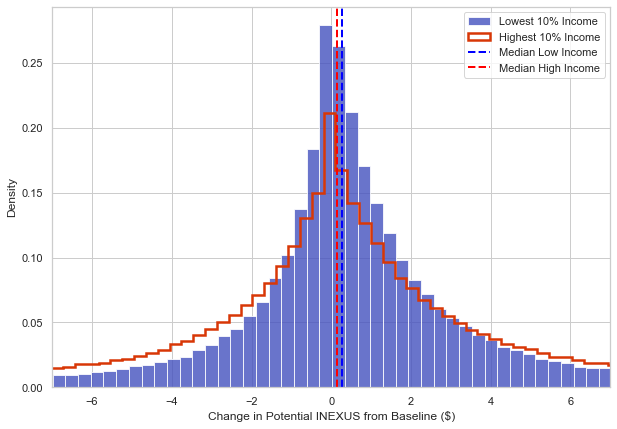

In [332]:
df = plot_free_base

# Separate data for low and high-income groups
low_income = df[df['income_deciles'] == '1stD']
high_income = df[df['income_deciles'] == '10thD']

# Calculate medians
median_low = low_income['potential_in_dollar_2023_relative_to_baseline'].median()
median_high = high_income['potential_in_dollar_2023_relative_to_baseline'].median()

# Create a figure and axes
plt.figure(figsize=(10, 7))

# Plot a solid histogram for low income with density=True
plt.hist(low_income['potential_in_dollar_2023_relative_to_baseline'], bins=350, alpha=0.8, density=True, color='#4451BF', label='Lowest 10% Income')

# Plot a non-solid histogram for high income with density=True
plt.hist(high_income['potential_in_dollar_2023_relative_to_baseline'], bins=350, alpha=1, density=True, histtype='step', edgecolor='#D83706', linewidth=2.5, label='Highest 10% Income')

# Add KDE line for low income with density=True
#sns.kdeplot(low_income['potential_in_dollar_2023_relative_to_baseline'], color='blue', linestyle='--', linewidth=2, density=True)

# Add KDE line for high income with density=True
#sns.kdeplot(high_income['potential_in_dollar_2023_relative_to_baseline'], color='red', linestyle='--', linewidth=2, density=True)

# Set y-axis label to 'Density'
plt.gca().set_ylabel('Density')

# Customize the legend
plt.legend()

# Set x-axis limits
plt.xlim(-7, 7)

# Add vertical lines for medians
plt.axvline(x=median_low, color='blue', linestyle='dashed', linewidth=2, label='Median Low Income')
plt.axvline(x=median_high, color='red', linestyle='dashed', linewidth=2, label='Median High Income')

# Add titles and labels
plt.xlabel('Change in Potential INEXUS from Baseline ($)')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

#### Figure 6 and  7 - Boxplot INEXUS relative to baseline

In [26]:
sf_stacked_rh_price["mode_actual_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_actual_BEAM"], None)

In [27]:
sf_stacked_rh_price["mode_actual_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_actual_baseline'].transform(lambda x: x.ffill().bfill())

In [28]:
#sf_stacked_rh_price["mode_planned_baseline"] = np.where(sf_stacked_rh_price['lever_position']==1, sf_stacked_rh_price["mode_choice_planned_BEAM"], None)
#sf_stacked_rh_price["mode_planned_baseline"] = sf_stacked_rh_price.groupby(['IDMerged','tripIndex'])['mode_planned_baseline'].transform(lambda x: x.ffill().bfill())
#same_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] == sf_stacked_rh_price['mode_choice_planned_BEAM']]
#diff_mode_planned = sf_stacked_rh_price[sf_stacked_rh_price['mode_planned_baseline'] != sf_stacked_rh_price['mode_choice_planned_BEAM']]

In [29]:
same_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] == sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [30]:
diff_mode_actual = sf_stacked_rh_price[sf_stacked_rh_price['mode_actual_baseline'] != sf_stacked_rh_price['mode_choice_actual_BEAM']]

In [34]:
#PRGn   PiYG  PuOr RdBu  RdGy_r RdYlBu  RdYlGn  YlGnBu   mako  BuGn YlGn_r 

CPU times: total: 2min 24s
Wall time: 2min 24s


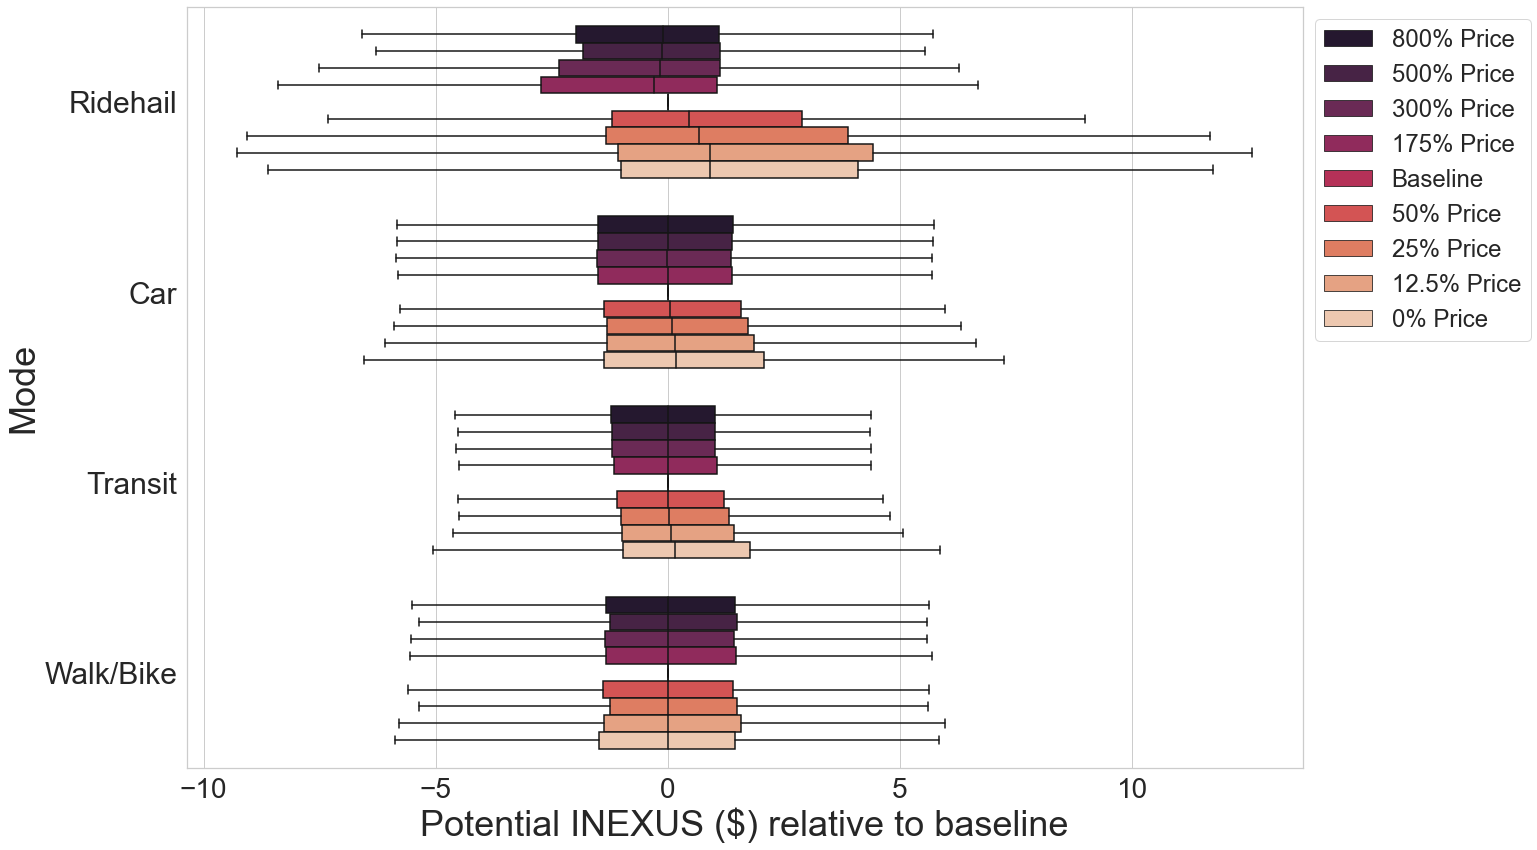

In [32]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="potential_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_potential_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_potential_2023.png', bbox_inches='tight', dpi = 300)

CPU times: total: 2min 20s
Wall time: 2min 20s


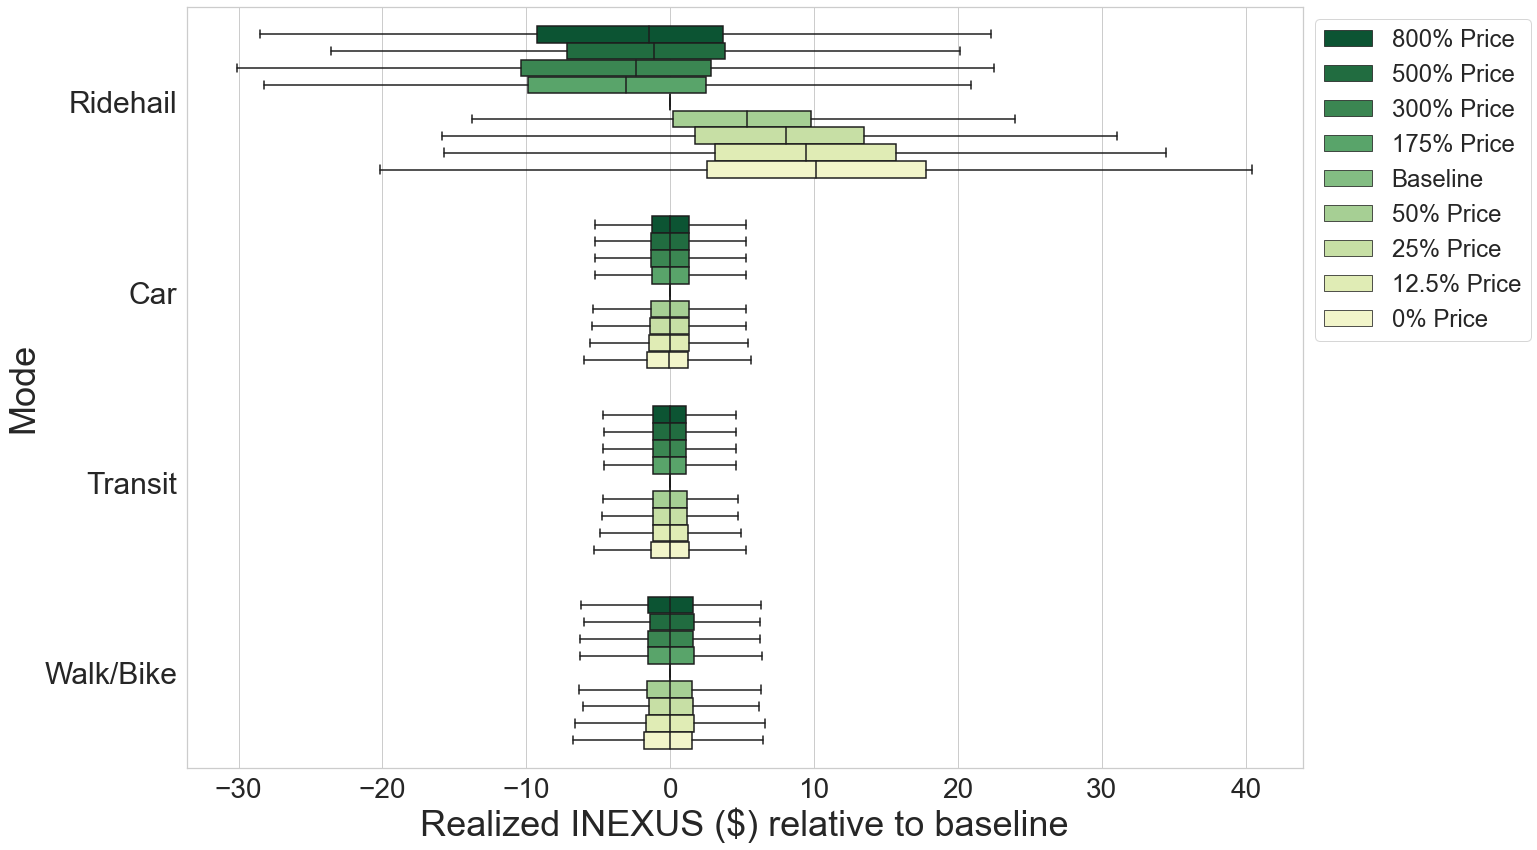

In [39]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="realized_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="YlGn_r", showfliers=False)
ax.set_xlabel('Realized INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_realized_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_realized_2023.png', bbox_inches='tight', dpi = 300)

#### Figure 8 - Income_Rank INEXUS plot

In [12]:
def process_income_data(dataframe):
    small_stacked_rh_price = dataframe[['lever_position_price','income_deciles','IDMerged','tripIndex',
                                        'income', 'realized_in_dollar_2023_relative_to_baseline', 
                                        'Realized_INEXUS_in_dollar_2023', 'potential_in_dollar_2023_relative_to_baseline',
                                        'Potential_INEXUS_in_dollar_2023', 'mode_choice_actual_4', 'duration_door_to_door',
                                        'waitTime_no_replanning','waitTime_replanning', 'mode_choice_planned_BEAM',
                                        'mode_choice_actual_BEAM','mode_actual_baseline']]
    
    small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000
    
    person_income = pd.pivot_table(
        small_stacked_rh_price,
        index=['IDMerged'],
        aggfunc={'incomeInThousands': lambda x: ', '.join(set(x.dropna().astype(str)))}).reset_index()
    
    person_income['incomeInThousands'] = person_income['incomeInThousands'].astype(float)
    
    twenty_one_ranks = person_income['incomeInThousands'].quantile([
        0, 0.048, 0.095, 0.143, 0.191, 0.239, 0.287, 0.335, 0.383, 0.431, 0.479,
        0.527, 0.575, 0.623, 0.671, 0.719, 0.767, 0.815, 0.863, 0.911, 0.959, 1
    ]).tolist()
    
    conditions = [
        (person_income['incomeInThousands'] >= twenty_one_ranks[i]) & 
        (person_income['incomeInThousands'] <= twenty_one_ranks[i+1])
        for i in range(21)
    ]
    
    choices = list(range(21))
    
    person_income['incomeRank'] = np.select(conditions, choices, default=None)
    
    smaller_stacked_rh_price = pd.merge(left = small_stacked_rh_price, right = person_income, how='left', on = ['IDMerged'], suffixes=('', '_drop'))
    smaller_stacked_rh_price.drop([col for col in smaller_stacked_rh_price.columns if 'drop' in col], axis=1, inplace=True)
    
    lorenz_data = pd.pivot_table(
        smaller_stacked_rh_price,
        index=['lever_position_price', 'incomeRank'],
        aggfunc={'incomeInThousands': np.mean,
                 'Potential_INEXUS_in_dollar_2023': np.mean,
                 'Realized_INEXUS_in_dollar_2023': np.mean,
                 'realized_in_dollar_2023_relative_to_baseline': np.mean,
                 'potential_in_dollar_2023_relative_to_baseline': np.mean}).reset_index() 
    return lorenz_data

In [13]:
lorenz_data = process_income_data(sf_stacked_rh_price)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_11116\2388425759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_stacked_rh_price['incomeInThousands'] = small_stacked_rh_price['income'] / 1000


In [14]:
palette = {
    8: '#521e4d',
    5: '#8e1d5b',
    3: '#ad1759',
    1.75: '#ca1a50',
    1: '#e13243',
    0.5: '#ee543f',
    0.25: '#f37751',
    0.125: '#f5966d',
    0: '#f7d0b5'}

In [15]:
lorenz_data['incRank_percent'] = (lorenz_data['incomeRank'])*5

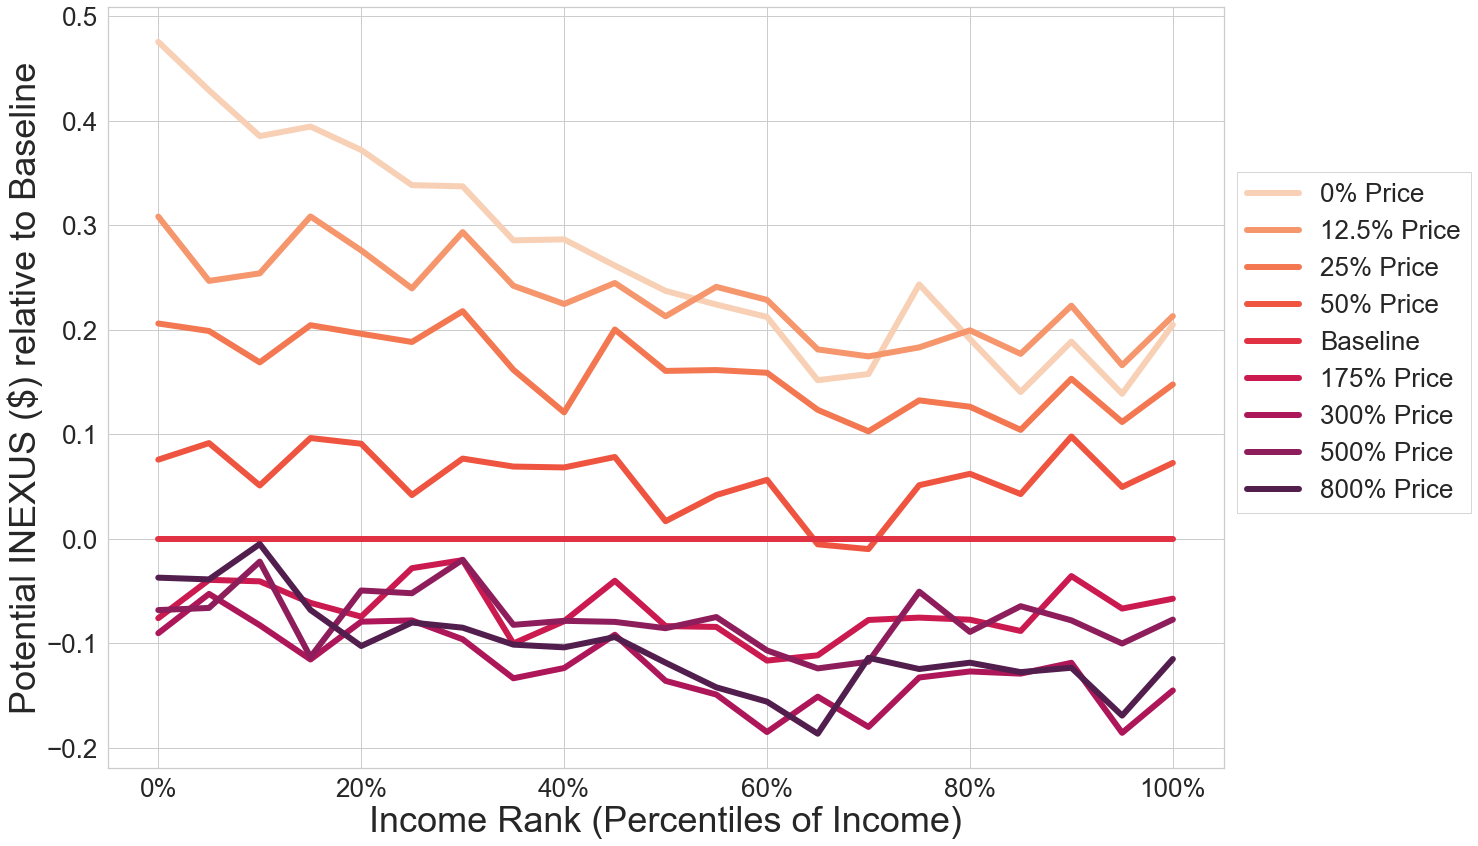

In [25]:
import matplotlib.ticker as ticker
sns.set(rc={'figure.figsize':(20,14)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.lineplot(data = lorenz_data, x = (lorenz_data['incomeRank'])*5, 
                  y = 'potential_in_dollar_2023_relative_to_baseline', hue = 'lever_position_price', palette = palette, ci=None, linewidth = 6)
ax.set_xlabel('Income Rank (Percentiles of Income)', fontsize = 36) #45
ax.set_ylabel('Potential INEXUS ($) relative to Baseline', fontsize = 36) #45
ax.yaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_tick_params(labelsize = 26) #35
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x)}%'))
plt.legend(labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1, 0.8), ncol=1, frameon=True, loc = 'best', prop={'size': 26}) #35
plt.savefig('lorenz.png', format='png', dpi=300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], fancybox=False, bbox_to_anchor=(1, 0.8), fontsize=26),), bbox_inches='tight') #30
#plt.savefig('lorenz.png', dpi=300)

#### Consumer Surplus

In [28]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked_rh_price.loc[sf_stacked_rh_price['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"lever position {position}")
    print(f"Difference from baseline: {difference:.2f}")

lever position 0
Difference from baseline: 420917.31
lever position 0.125
Difference from baseline: 644312.07
lever position 0.25
Difference from baseline: 270044.91
lever position 0.5
Difference from baseline: -94702.34
lever position 1
Difference from baseline: 0.00
lever position 1.75
Difference from baseline: -364788.02
lever position 3
Difference from baseline: -619843.06
lever position 5
Difference from baseline: -312672.03
lever position 8
Difference from baseline: -659898.92


In [54]:
income_decile = '10thD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price.loc[(sf_stacked_rh_price['lever_position_price'] == position) & (sf_stacked_rh_price['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked_rh_price.loc[(sf_stacked_rh_price['lever_position_price'] == 1) & (sf_stacked_rh_price['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"lever position {position}")
    print(f"Difference from baseline: {difference:.2f}")

lever position 0
Difference from baseline: 9402.91
lever position 0.125
Difference from baseline: 60019.16
lever position 0.25
Difference from baseline: 21567.57
lever position 0.5
Difference from baseline: -12658.23
lever position 1
Difference from baseline: 0.00
lever position 1.75
Difference from baseline: -40243.68
lever position 3
Difference from baseline: -77166.07
lever position 5
Difference from baseline: -31391.00
lever position 8
Difference from baseline: -82581.33


In [55]:
income_decile = '1stD'
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked_rh_price.loc[(sf_stacked_rh_price['lever_position_price'] == position) & (sf_stacked_rh_price['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked_rh_price.loc[(sf_stacked_rh_price['lever_position_price'] == 1) & (sf_stacked_rh_price['income_deciles'] == income_decile), 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"lever position {position}")
    print(f"Difference from baseline: {difference:.2f}")

lever position 0
Difference from baseline: 114229.67
lever position 0.125
Difference from baseline: 73111.14
lever position 0.25
Difference from baseline: 37684.40
lever position 0.5
Difference from baseline: 6853.39
lever position 1
Difference from baseline: 0.00
lever position 1.75
Difference from baseline: -23398.11
lever position 3
Difference from baseline: -34998.67
lever position 5
Difference from baseline: -21761.38
lever position 8
Difference from baseline: -30988.88
